# [Phystech@DataScience](https://thetahat.ru/courses/ph-ds-2025-spr)

In [ ]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    fbeta_score,
    precision_recall_curve,
    auc,
    average_precision_score,
    classification_report,
)
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="dark", font_scale=1.7)

## Метрики качества в задачах классификации

### 1. Построение модели

#### 1.1. Данные

Для дальнейшего изучения метрик качества сгенерируем выборку при помощи `make_blobs` из `sklearn` с двумя признаками, чтобы обучить и протестировать на ней логистическую регрессию. Классы не сбалансированы и линейно не разделимы.

In [ ]:
X, y = make_blobs(
    n_samples=(500, 50),
    centers=[[2, 2], [-2, -2]],
    cluster_std=2.5,
    random_state=42,
)

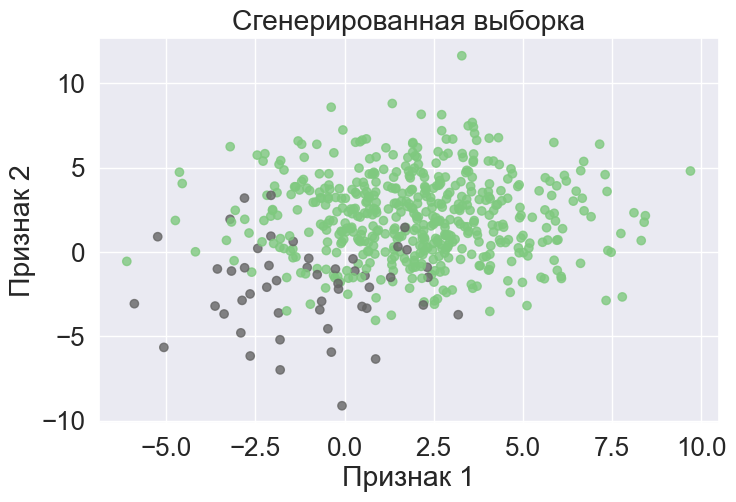

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("Сгенерированная выборка")
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap="Accent")
plt.grid()
plt.xlabel("Признак 1"), plt.ylabel("Признак 2")
plt.show()

Разделим данные на тренировочную и тестовую выборку:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Выведем размерности выборок:

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((385, 2), (165, 2), (385,), (165,))

#### 1.2. Модель

Определим модель логистической регресии и обучим ее:

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

Выведем коэффициенты модели:

In [ ]:
clf.coef_

array([[-0.57299364, -0.87707157]])

Выведем коэффициент перед свободным параметром:

In [ ]:
clf.intercept_

array([-2.07537329])

#### 1.3. Результат

График предсказаний вероятности принадлежности классу:

In [ ]:
x0_grid, x1_grid = np.meshgrid(
    np.linspace(-10, 10, 2001), np.linspace(-10, 10, 2001)
)
ravel_grid = np.array([x0_grid, x1_grid]).reshape((2, 2001 * 2001)).T
prob_grid = clf.predict_proba(ravel_grid)
prob_grid = prob_grid[:, 0].reshape((2001, 2001))

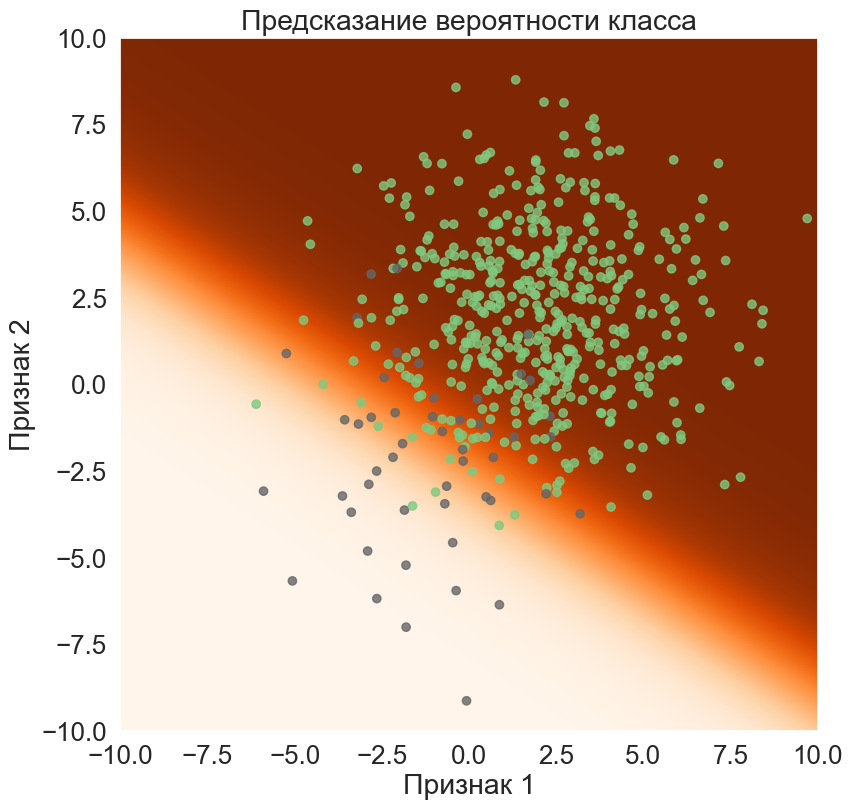

In [ ]:
plt.figure(figsize=(9, 9))
plt.pcolormesh(x0_grid, x1_grid, prob_grid, cmap="Oranges")
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap="Accent")
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("Признак 1"), plt.ylabel("Признак 2")
plt.title("Предсказание вероятности класса");

### 2. Метрики качества классификации (пороговые)

Для бинарной классификации существует множество различных метрик качества. Для начала рассмотрим самые основные.

#### 2.1. Accuracy (доля правильных ответов)

[Accuracy в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Данная метрика является самой тривиальной метрикой для задачи классификации и представляет собой долю правильных ответов:

$$accuracy(y, \widehat{y}) = \frac{1}{n}\sum\limits_{i=1}^{n} {I\{\widehat{y}_i=y_i\}},$$   
  
где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов, $n$ &mdash; количество объектов.

**Достоинство**: в основе метрики $accuracy$ лежит простая интуиция.

**Недостаток**: данная метрика плоха в случае дисбаланса классов, когда представителей одного из класса существенно больше, чем другого.

&#x2753; **Вопрос** &#x2753;


> Почему данная метрика неинформативна в таком случае?


<details>
 <summary> Кликни для показа ответа </summary>

> Рассмотрим пример выборки, в которой $950$ положительных и $50$ отрицательных объектов. Пусть наш классификатор всем объектам выдает класс $1$. Тогда его $accuracy = 0.95$, что является очень неплохим результатом. Однако сама модель при этом не имеет особого смысла: она просто возвращает константу при любом входе.
\
Это означает, что доля правильных ответов сама по себе не несет никакой информации о качестве работы модели, и вместе с ней следует анализировать соотношение классов в выборке.
</details><br/>



**Пример вычисления**

Вычислим $accuracy$ для нашей задачи:

In [ ]:
accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 0.927


В данной ситуации эта метрика не очень информативна, так как классификатор, предсказывающий всегда 1 класс, имел бы accuracy $\approx 90\%$

#### 2.2. Confusion matrix (матрица ошибок)

[Confusion matrix в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Рассмотрим  матрицу ошибок (confusion matrix) – матрицу размера $2 \times 2$, $ij$-я позиция которой равна числу объектов $i$-го класса, которым модель присвоила метку $j$-го класса. Данное понятие нужно осознать и запомнить, так как на основе данной матрицы будут введены более сложные метрики.

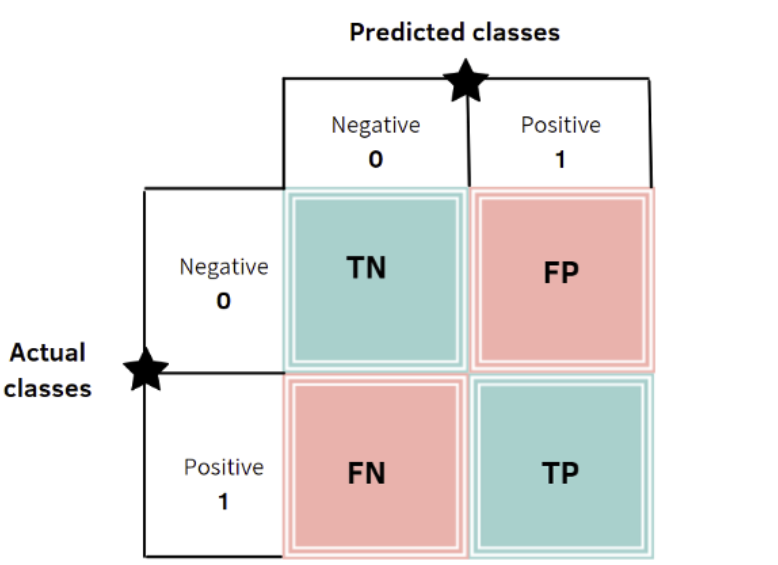

**TN** &mdash; True Negative, количество верно (True) предсказанных объектов среди тех, которым модель присвоила негативный (Negative) класс.  
**FP** &mdash; False Positive, количество неверно (False) предсказанных объектов среди тех, которым модель присвоила позитивный (Positive) класс.  
**FN** &mdash; False Negative, количество неверно (False) предсказанных объектов среди тех, которым модель присвоила негативный (Negative) класс.  
**TP** &mdash; True Positive, количество верно (True) предсказанных объектов среди тех, которым модель присвоила позитивный (Positive) класс.  




Отметим, что в данной терминологии $accuracy$ можно представить через следующую формулу:  
<br>
$$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Пример**

Пусть мы хотим оценить работу спам-фильтра почты. У нас есть $100$ не-спам писем, $90$ из которых наш классификатор определил верно и $10$ спам-писем, $5$ из которых классификатор также определил верно. Будем считать класс не-спам писем отрицательным, а класс спам писем &mdash; положительным. Обозначим количество объектов отрицательного класса $N_0$, а положительного $N_1$, тогда:

$$
N_0 = TN + FP = 100,
\\
N_1 = TP + FN = 10.
$$


Итого:

<details>
 <summary> Кликни для показа ответа </summary>

* Из $100$ не-спам писем $90$ были определены верно $\Rightarrow TN = 90, \; FP = 10$;

* Из $10$ спам писем 5 были определены верно $\Rightarrow TP = 5, \; FN = 5$.
</details><br/>



Данная матрица сама по себе является не метрикой, а инструментом, с помощью которого можно ввести более продвинутые метрики. Тем не менее ее полезно визуализировать, так как она является достаточно информативной.

**Пример вычисления**

Вычислим матрицу ошибок для нашей задачи:

In [ ]:
matrix = confusion_matrix(y_test, clf.predict(X_test))
(TN, FP), (FN, TP) = matrix
print(f"TN = {TN}")
print(f"FP = {FP}")
print(f"FN = {FN}")
print(f"TP = {TP}")

TN = 145
FP = 4
FN = 8
TP = 8


#### 2.3. Precision (точность)

[Precision в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

Точность (Precision, Positive Predictive Value) показывает какой процент объектов, которые метод посчитал положительными, действительно являются положительными:

$$precision(y, \widehat{y}) = \frac{TP}{TP + FP},$$

где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов.


**Пример:**

Рассмотрим задачу предсказания реакции клиента банка на звонок с предложением кредита.
Класс $y = 1$ означает, что клиент возьмет кредит после рекламного звонка, класс $y = -1$, что не возьмет.
Планируется обзванивать только тех клиентов, которых классификатор отнесет к классу $1$.
Если классификатор имеет высокую точность, то практически все клиенты, которым будет сделано предложение, откликнутся на него.

**Достоинство**: позволяет следить за тем, насколько можно доверять модели, если она предсказывает позитивный класс.

**Недостаток**: не позволяет следить за тем, как много положительных объектов способен распознать классификатор.

Например, мы построили модель, которая присваивает позитивный класс очень малому количеству объектов. $Precision$ у такой модели может быть хорошим, но при этом модель присваивает негативный класс очень большому количеству позитивных объектов.

**Пример вычисления**

Вычислим $precision$ для нашей задачи:

In [ ]:
precision = precision_score(y_test, clf.predict(X_test))
print(f"Precision = {precision:.3f}")

Precision = 0.667


#### 2.4. Recall (полнота)

[Recall в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

Полнота (Recall, True Positive Rate) показывает какую долю объектов положительного класса модель классифицировала правильно:

$$recall(y, \widehat{y}) = \frac{TP}{TP + FN},$$

где $y$ &mdash; вектор истинных классов, $\widehat{y}$ &mdash; вектор предсказанных классов.


**Пример:**

Рассмотрим тот же пример предсказания реакции клиента банка на звонок с предложением кредита.<br>
Если классификатор имеет высокую полноту, то предложение будет сделано практически всем клиентам, которые готовы откликнуться на него.

**Достоинство**: позволяет следить за тем, как много положительных объектов способен распознать классификатор.

**Недостаток**: не позволяет следить за тем, насколько можно доверять модели, если она предсказывает позитивный класс.

*Замечание 1.*

1. Легко построить модель с $recall = 1$.


&#x2753; **Вопрос** &#x2753;


> Как работает эта модель?


<details>
 <summary> Кликни для показа ответа </summary>

> Она все объекты относит к классу $1$, но при этом $precision$ может быть очень низким.
</details><br/>


2. Нетрудно построить модель с $precision$ близким к $1$.

&#x2753; **Вопрос** &#x2753;


> А как работает эта модель?


<details>
 <summary> Кликни для показа ответа </summary>

> Она относит к классу $1$ только те объекты, в которых точно уверена, при этом $recall$ может быть низким.
</details><br/>



*Замечание 2.*

Отметим, что точность и полнота не зависят от соотношения размеров классов. Даже если объектов положительного класса на порядки меньше, чем объектов отрицательного класса, данные показатели будут корректно отражать качество работы модели.

**Пример вычисления**

Вычислим $recall$ для нашей задачи:

In [ ]:
recall = recall_score(y_test, clf.predict(X_test))
print(f"Recall = {recall:.3f}")

Recall = 0.500


#### 2.5. Precision vs. recall

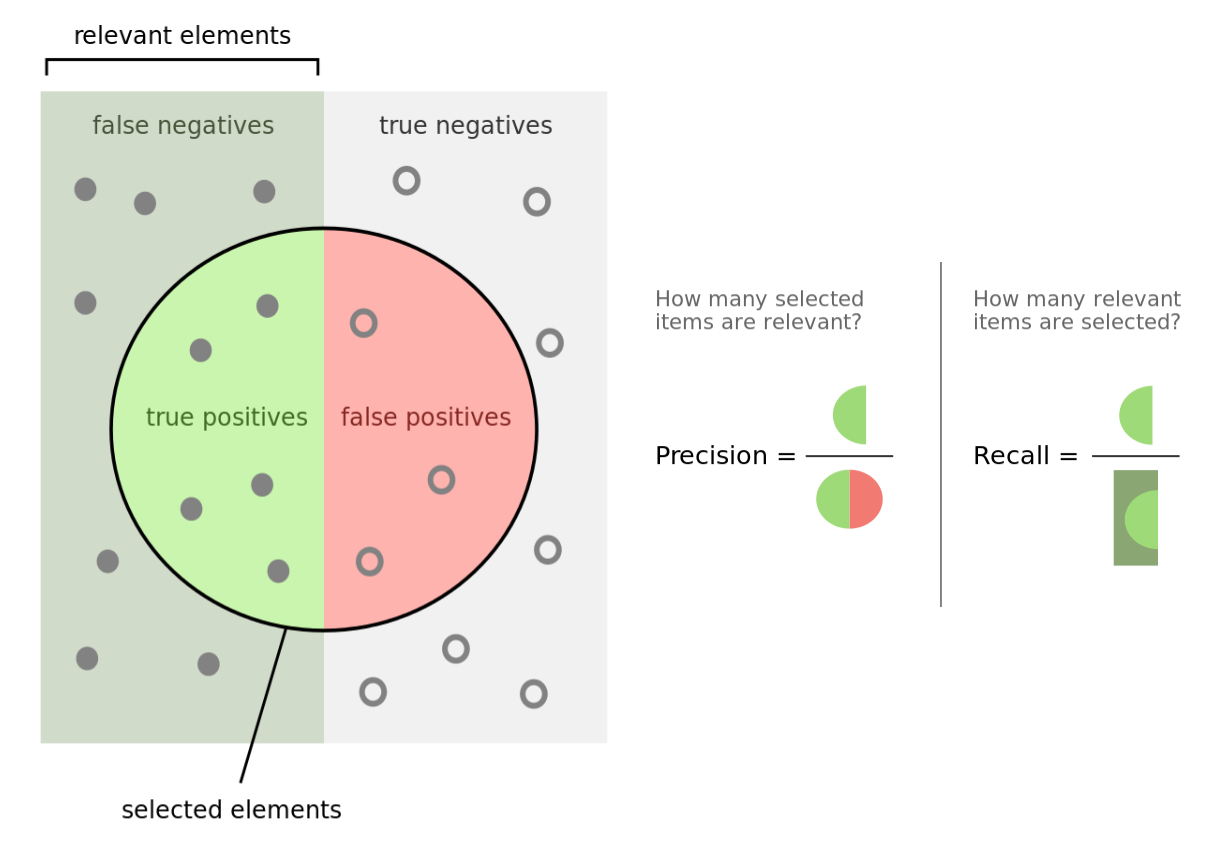


#### 2.6. $F_1$-мера
[$F_1$-мера в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)


Хотелось бы получить один критерий, который учитывал бы в себе и точность, и полноту. Существует несколько способов получить один критерий качества на основе точности и полноты.
Один из них &mdash; $F_1$-мера, гармоническое среднее точности и полноты:

$$F_1 = \frac{ 2 \cdot precision \cdot recall}{precision + recall}$$

Среднее гармоническое обладает важным свойством &mdash; оно близко к нулю, если хотя бы один из аргументов близок к нулю.
При этом $F_1$ достигает максимума при $precision = 1$ и $recall = 1$.

*Замечание.*

Иногда эту метрику просто называют $F$-мерой.

Рассмотрим другие методы агрегации $precision$ и $recall$. Они не используются, но полезно увидеть их недостатки в сравнении со средним гармоническим.

1. Среднее арифметическое
$$A = \frac{precision + recall}{2}$$
**Недостатки:**

Пусть есть выборка, в которой $10\%$ объектов &mdash; класс $1$.

&#x2753; **Вопрос** &#x2753;

>  Модель $a_1$ всегда выдает класс 1. Чему равны $precision$ и $recall$?


<details>
 <summary> Кликни для показа ответа </summary>

> $\Rightarrow precision_{1} = 0.1, recall_{1} = 1$ <br>
$\Rightarrow A_1 = 0.55$ <br>
</details><br/>


> Модель $a_2$ имеет $precision_{2} = 0.55, recall_{1} = 0.55$ <br>
$\Rightarrow A_2 = 0.55$ <br>

Среднее арифметическое обеих моделей одинаково, однако первая модель совсем бесполезная, а вторая хоть как-то умеет различать классы.


2. Минимум
$$M = \min(precision, recall)$$
Максимум достигается при $precision = 1$ и $recall = 1$. <br>
**Недостатки:** <br>

> Пусть модель $a_1$ имеет $precision_{1} = 0.4, recall_{1} = 0.9$ <br>
$\Rightarrow M_1 = 0.4$ <br>
А модель $a_2$ имеет $precision_{2} = 0.4, recall_{2} = 0.5$ <br>
$\Rightarrow M_2 = 0.4$ <br>

Минимумы двух моделей одинаковы, однако очевидно, что первая модель гораздо лучше.



&#x2755; Можно заметить, что $F_1$-мера по сути является сглаженной версией минимума из точности и полноты и поэтому она лишена минусов двух рассмотренных метрик.

Визуализируем различные методы агрегации $precision$ и $recall$.

In [ ]:
precision_grid = np.linspace(0, 1, 100)[1:]
recall_grid = np.linspace(0, 1, 100)[1:]
precision_mesh, recall_mesh = np.meshgrid(precision_grid, recall_grid)
mean_values = (precision_mesh + recall_mesh) / 2
min_values = np.minimum(precision_mesh, recall_mesh)
f1_values = 2 * precision_mesh * recall_mesh / (precision_mesh + recall_mesh)

levels = np.linspace(0, 1, 15)

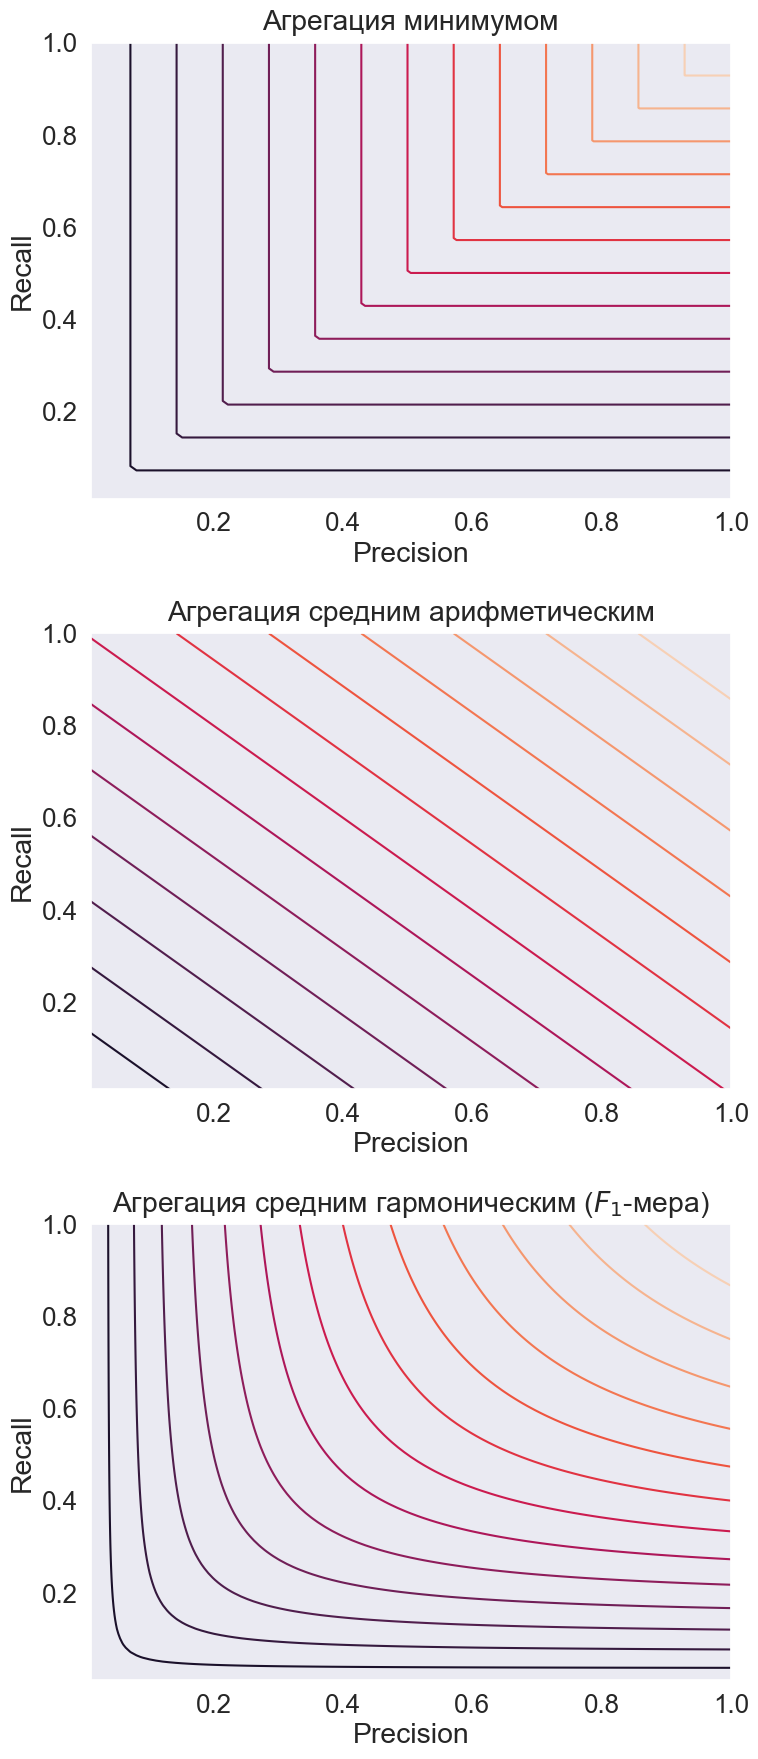

In [ ]:
plt.figure(figsize=(8, 18))

plt.subplot(3, 1, 1)
plt.contour(precision_grid, recall_grid, min_values, levels=levels)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Агрегация минимумом", y=1.01)

plt.subplot(3, 1, 2)
plt.contour(precision_grid, recall_grid, mean_values, levels=levels)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Агрегация средним арифметическим", y=1.01)

plt.subplot(3, 1, 3)
plt.contour(precision_grid, recall_grid, f1_values, levels=levels)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Агрегация средним гармоническим ($F_1$-мера)", y=1.01)

plt.tight_layout()
plt.show()

**Пример вычисления**

Вычислим $F_1$-меру для нашей задачи:

In [ ]:
f1 = f1_score(y_test, clf.predict(X_test))
print(f"F1 = {f1:.3f}")

F1 = 0.571


#### 2.6.1. Обобщенная F-мера ($F_{\beta}$-мера)

[$F_{\beta}$-мера в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score)

Обобщением $F_1$-меры является $F_{\beta}$-мера, которая равна взвешенному гармоническому precision и recall с коэффициентом $\beta$:

$$F_{\beta} = (1 + \beta^2)\frac{ precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$

В данном случае $\beta$ определяет вес точности в метрике.

Эта метрика хороша в тех задачах, где от нас требуется обращать больше внимания на один из параметров precision или recall.

$0 < \beta < 1 \Rightarrow $ важнее $precision$

$\beta = 1 \Rightarrow $ получаем среднее гармоническое, то есть $F_1$-меру

$1 < \beta < +\infty \Rightarrow $ важнее $recall$

>Одним из примеров задач, в которых полезно вычислять именно $F_{\beta}$ с $\beta \ne 1$, является задача предсказания болезни.
В такой задаче гораздо важнее recall, нежели precision: лучше здоровому человеку сказать, что он болен и проверить его более тщательно, чем не определить больного.

Посчитаем $F_\beta$-мера для нашей задачи:

In [ ]:
fbeta = fbeta_score(y_test, clf.predict(X_test), beta=2)
print(f"FBeta-score (beta=2): {fbeta:.3f}")

FBeta-score (beta=2): 0.526


### 3. Беспороговые метрики

Многие модели классификации не предсказывают напрямую класс, а выдают вероятности принадлежности к каждому классу, которые затем еще нужно каким-то образом преобразовать в конкретные классы для оценки метрик.

В случае бинарной классификации простейший метод преобразования вероятностей &mdash; это **бинаризация** по порогу. Например, часто берут порог равный 0.5 и если вероятность $p < 0.5$, мы рассматриваем предсказание как класс 0 (отрицательный класс), если же вероятность $p \geqslant 0.5$, предсказание считается класcом 1 (положительный класс).

Однако порог 0.5 не является обязательным. Мы можем настроить его, чтобы улучшить качество предсказания модели в зависимости от конкретной задачи и модели. Это приводит к понятию **пороговых метрик** &mdash; метрик, которые зависят от выбранного порога. Именно такими и являются все рассмотренные ранее метрики: *accuracy*, *precision*, *recall*, *$F_1$-мера*.

С другой стороны, существуют и **беспороговые метрики**, которые работают непосредственно с вероятностями и не зависят от выбора порога. С такими метриками мы познакомимся ниже.

#### 3.1. Площадь под ROC-кривой (Area Under ROC Curve, AUC-ROC)

[AUC-ROC в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc)

При переводе вещественнозначного ответа модели (например, в логистической регрессии, вероятности принадлежности к классу $1$) в бинарную метку {$0$, $1$}, мы должны выбрать порог перехода. Обычно, таким порогом является $0.5$, но такой выбор не всегда является оптимальным, например, при отсутствии балансов классов.

Ранее изученные метрики (precision, recall, accuracy) характеризуют точность работы модели при конкретно выбранном пороге $t$ бинарной классификации.

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является **AUC-ROC**. Данная кривая представляет из себя кривую от $(0,0)$ до $(1,1)$ в координатах **True Positive Rate (TPR)** и **False Positive Rate (FPR)**.

Для понимания того, что такое TPR и FPR вспомним матрицу ошибок:

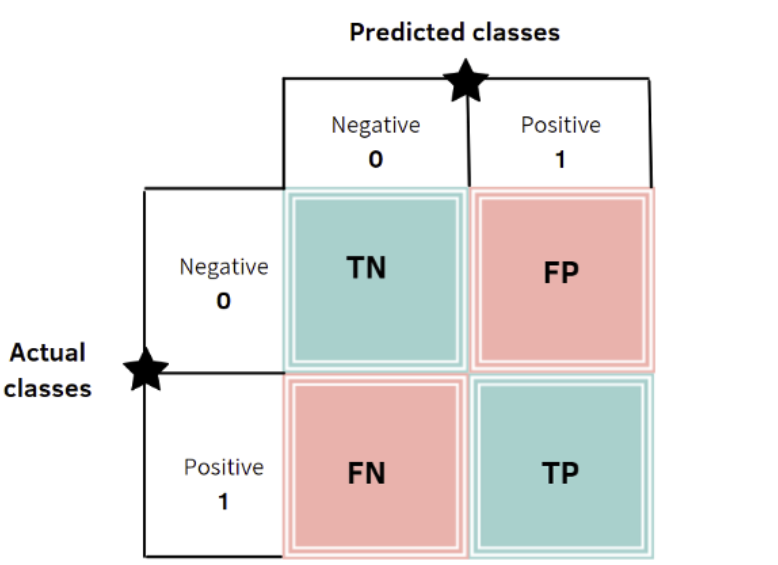


В приведенной ниже терминологии мы считаем класс с меткой $1$ положительным, а с меткой $0$ &mdash; негативным

**TPR (True Positive Rate)** показывает какую долю объектов положительного класса модель классифицировала правильно:

$$TPR = \dfrac{TP}{TP + FN}$$

&#x2753; **Вопрос** &#x2753;

> Какую ранее рассмотренную метрику отражает TPR?

<details>
 <summary> Кликни для показа ответа </summary>

> Recall, иначе sensitivity или полнота
</details><br/>


**FPR (False Positive Rate)** показывает, какую долю из объектов негативного класса модель предсказала неверно:

$$FPR = \dfrac{FP}{FP + TN}$$


Каждая точка на графике соответствует выбору некоторого порога бинарной классификации $t$.

Кривая рисуется следующим образом:
- мы перебираем пороги, начиная с $1$ и до $0$.
- При $t = 1$ всем объектам присваивается класс $0$, значит мы находимся в точке $(0, 0)$
- уменьшаем $t$ до тех пор пока TPR и FPR не изменяются. Когда изменились, отмечаем точку (FPR , TPR) на графике
- продолжаем алгоритм до тех пор, пока все точки не будут рассмотрены

Площадь под кривой в данном случае показывает качество модели: чем она больше, тем классификатор лучше.


Также важным является крутизна самой кривой &mdash; мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке $(0,1)$.

В идеальном случае, когда классификатор не делает ошибок (FPR = $0$, TPR = $1$) мы получим площадь под кривой, равную единице:

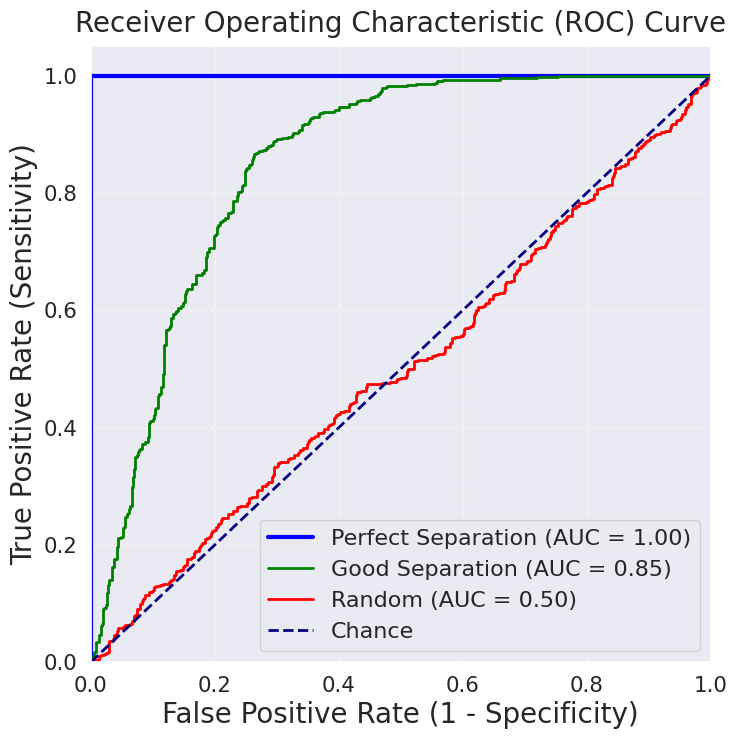

Заметим также, что FPR и TPR нормируются на размеры классов, поэтому AUC-ROC не поменяется при изменении баланса классов.

Посчитаем AUC-ROC для нашей задачи:

In [ ]:
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"AUC-ROC: {roc_auc:.3f}")

AUC-ROC: 0.929


Отрисуем ROC-кривую:

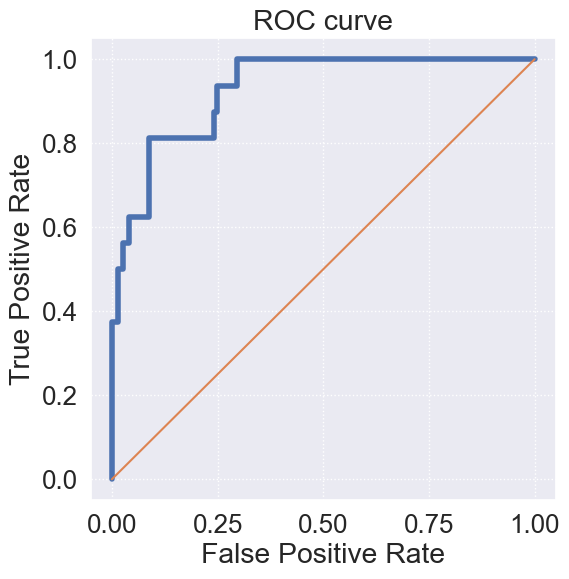

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=4, label="ROC curve")
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(ls=":")
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

> **Пример:**
>
>Попробуем проиллюстрировать почему подбор метрики под вашу задачу &mdash; это важно, и выбор первой попавшейся может привести к неудовлетворительным результатам.
>
>Рассмотрим задачу предсказания реакции клиента банка на звонок с предложением кредита. Пусть в действительности (в нашей обучающей выборке) $10$ клиентов из $100000$ приняли предложение о кредите после звонка.
>
>Рассмотрим два классификатора:
>
>1. Дает самую высокую вероятность 10 релеватным клиентам. Для такой модели:
>
>$$AUCROC = 1$$
>
>2. Располагает релеватных клиентов на позициях 10, 20, 30, 40, 50, 60, 70, 80, 90, 100.
>
>   Получим:

In [ ]:
y_true = np.zeros(100_000)
y_score = np.arange(100_000)[::-1]
y_true[np.arange(10, 101, 10)] = 1
roc_auc_value = roc_auc_score(y_true=y_true, y_score=y_score)
print(f"AUC-ROC: {roc_auc_value:.5f}")

AUC-ROC: 0.99949


>Видим, что показатель очень высокий. В самом деле, из всех возможных 100 тыс. позиций, модель поместила все релевантные в топ 100, весьма хороший результат. Вот только если в реальности каждый звонок стоит денег и несет свои риски, то нам хочется как можно чаще получать конверсию звонка в кредит.
>
>Имеем для первой модели:
>$$precision \leq 1$$
>
>Для второй:
>$$precision \leq 0.1$$
>
>И тут разница между моделями кратная.

##### Алгоритм подсчета

Рассмотрим алгоритм подсчета AUC-ROC за $O(n \log n)$.

Имеем:
* ответы: $y_1, \dots, y_n$;
* выходы модели: $p_1, \dots, p_n$.

Введем:
* $m_{+} = TP + FN$;
* $m_{-} = FP + TN$.

Упорядочим вероятности $O(n \log n)$:

$$
p_1, \dots, p_n \rightarrow p_{(n)}, \dots, p_{(1)}.
$$

Применим эту же перестановку к $y_1, \dots, y_n$.

Теперь опишем алгоритм $O(n)$.


```python
FPR = [0]*(n+1)
TRP = [0]*(n+1)
AUC = 0
for i in range(1, n+1):
    if y[i-1] == 1:
        FPR[i] = FPR[i-1]
        TPR[i] = TPR[i-1] + 1/m_plus
    else:
        FPR[i] = FPR[i-1] + 1/m_minus
        TPR[i] = TPR[i-1]
        AUC += 1/m_minus * TPR[i]
```

Стоит сразу отметить, что это упрощенная версия, которая не умеет обрабатывать корректно случаи, когда одному значению $p$ соответствует сразу множество точек. В таком ситуации нам следует шагать "по диагонали" как будто мы сразу обработали все эти точки за один раз.

#### 3.2. Площадь под PR-кривой (Area Under PR Curve, AUC-PR)

[AUC-PR в `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

Аналогично ROC-кривой, определим PR-кривую как кривую в координатах recall  и precision, начинающуюся в точке $(0, 0)$.

Каждая точка на графике соответствует выбору некоторого порога бинарной классификации $t$. Площадь под кривой в данном случае показывает качество модели: чем она больше, тем классификатор лучше.

При построении кривой перебираем порог от $1$ до $0$. Как только precision или recall меняется, наносим точку на график. <br>
При пороге $t=1$: recall = $0$, precision = $0$<br>
При пороге $t=0$: recall = $1$, precision = $TP / (TP + FP)$ (может как быть 1, так и быть меньше)<br>

*Замечание.*
>
>На графиках кажется, что кривая начинается из точки $(0, 1)$. Это связано с тем, что если $t$ находится в окрестности $1$, но при этом не равно $1$, то precision скорей всего будет большим и близким к единице. Более того, многие стандартные методы отрисовки PR-кривой пропускают точку $t = 1$ и начинают отрисовку со следующего значения $t$.

Также важным является "пологость" самой кривой &mdash; мы хотим максимизировать и precision и recall, а значит, наша кривая в идеале должна стремиться к точке $(1,1)$.

В идеальном случае, когда классификатор не делает ошибок (precision=$1$,  recall=$1$) мы получим площадь под кривой, равную единице:

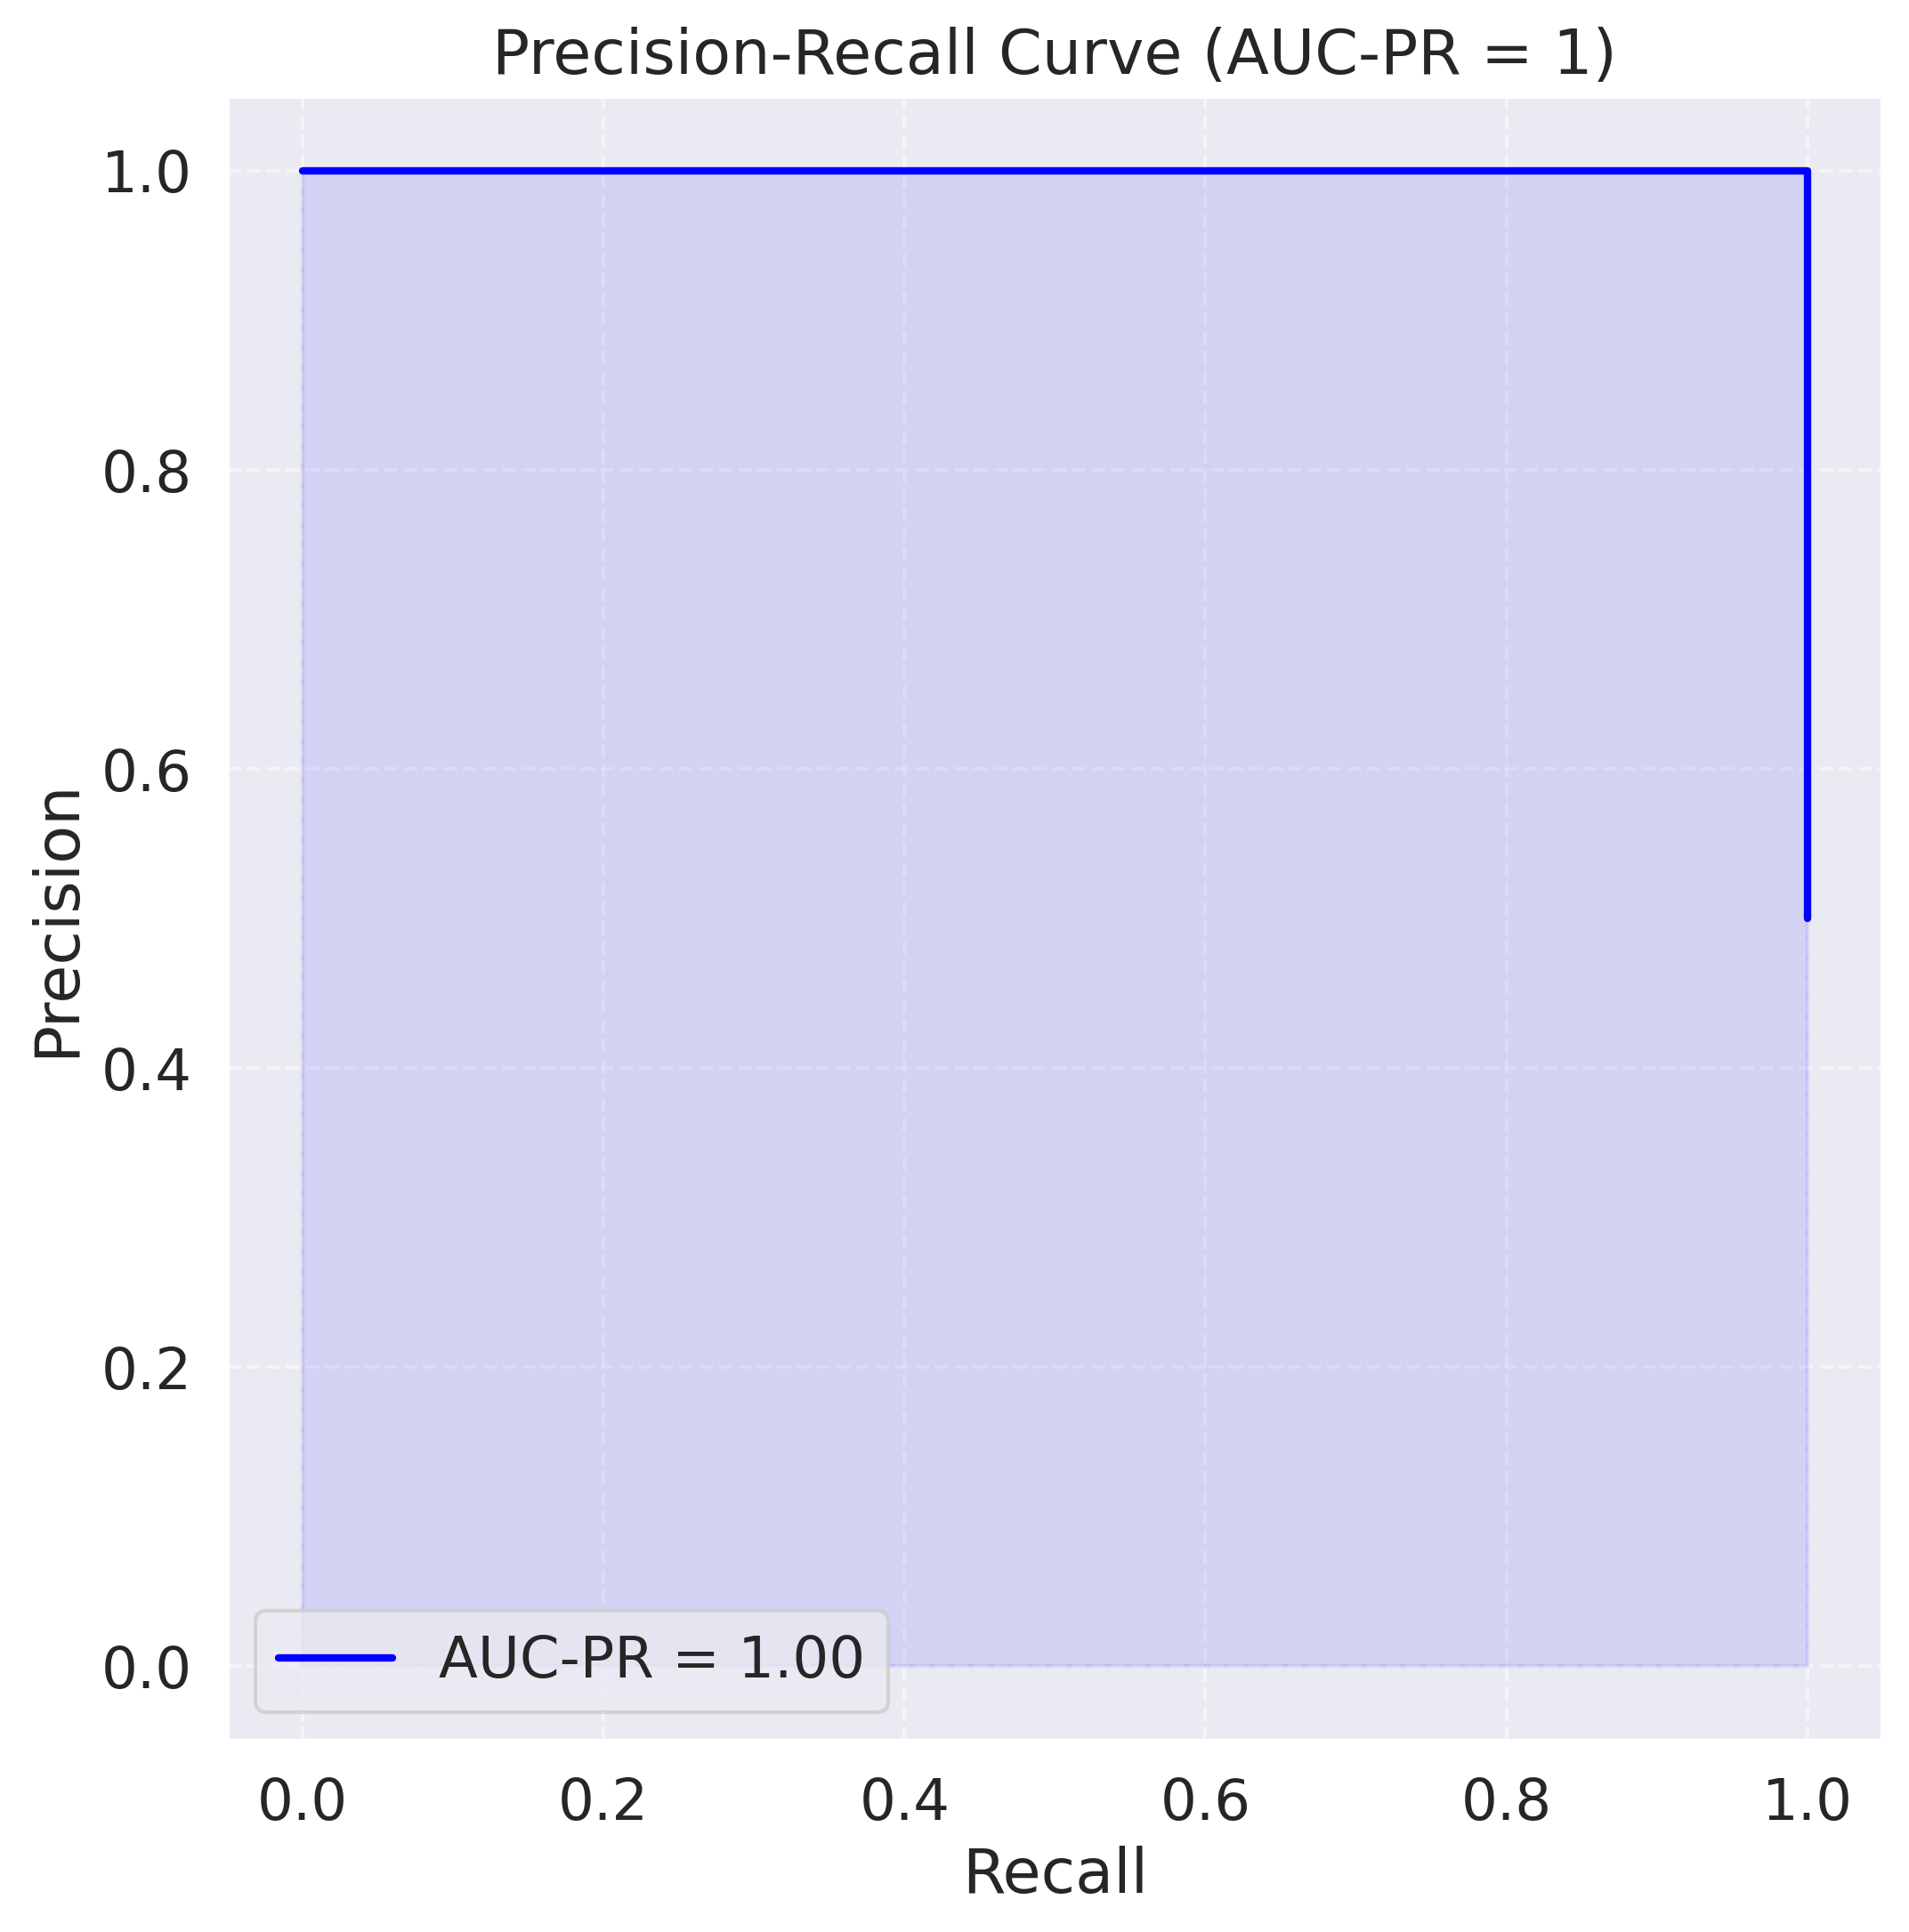


Отрисуем AUC-PR для нашей задачи:

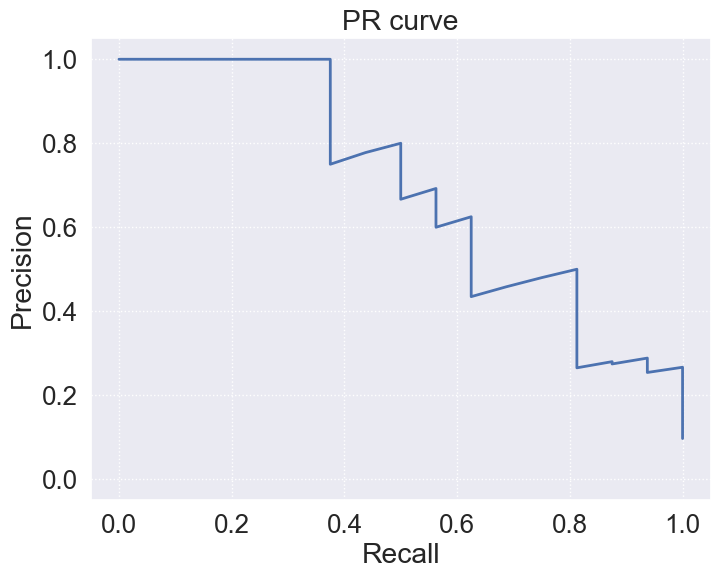

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(
    y_test, clf.predict_proba(X_test)[:, 1]
)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, lw=2, label="PR curve")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(ls=":")
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

А также посчитаем площадь под данной PR-кривой, воспользовавшись функцией `auc`, которая считает площадь под кривыми с помощью метода трапеций:

In [ ]:
auc_pr = auc(recalls, precisions)
print(f"AUC-PR: {auc_pr:.3f}")

AUC-PR: 0.692


Или же используя формулу для **Average precision**:

$$AP = \sum\limits_n (R_n - R_{n - 1}) P_n, $$

где $P_n$ и $R_n$ &mdash; precision и recall соответственно для $n$-ого порога классификации

In [ ]:
average_precision = average_precision_score(
    y_test, clf.predict_proba(X_test)[:, 1]
)
print(f"Average precision: {average_precision:.3f}")

Average precision: 0.698


### 4. Обобщение метрик классификации на многоклассовый случай.

Как правило, это усреднение метрик для бинарной классификации.

Бывает два вида усреднения: микро-усреднение и макро-усреднение.

1. **Микро-усреднение:** считаем характеристики (например: TP, FP, TN, FN) для бинарной классификации (один класс против всех) и усредняем их по всем классам. После этого считаем итоговую метрику по усредненным характеристикам. <br>
Например, точность будет вычисляться по формуле :
$$precision = \frac{\overline{TP}}{\overline{TP} + \overline{FP}},$$
где $\overline{TP} = \frac{1}{K} \sum\limits_{k = 1}^K TP_k$

2. **Макро-усреднение:** для каждого класса считаем итоговую метрику как для бинарной классификации (один класс против всех). После этого устредняем итоговую метрику по всем классам. <br>
Например, точность будет вычислена как
$$precision = \frac{1}{K} \sum\limits_{k = 1}^K precision_k,$$
где $precision_k = \frac{TP_k}{TR_k + FP_k}$

*Замечание.*
>* При микро-усреднении вклад каждого класса зависит от его размера. Действительно, размер класса сильно влияет на значения матрицы ошибок: TP, FP, TN, FN.
>
>* При макро-усреднении такого эффекта не наблюдается: каждый класс вносит равный вклад в итоговую метрику, так как итоговая метрика уже не зависит от размера классов.
>
>* Если модель плохо работает с маленькими классами, то метрика, полученная при макро-усреднении будет хуже (меньше, если мы максимизируем метрику), чем при микро-усреднении (ведь при макро-усреднении маленькие классы внесли такой же вклад, что и большие).

Посчитаем микро-усреднение и макро-усреднение для $F_1$-меры в задаче трехклассовой классификации

In [ ]:
X, y = make_blobs(
    n_samples=(500, 250, 50),
    centers=[[2, 2], [-2, -2], [2, -2]],
    cluster_std=2.5,
    random_state=42,
)

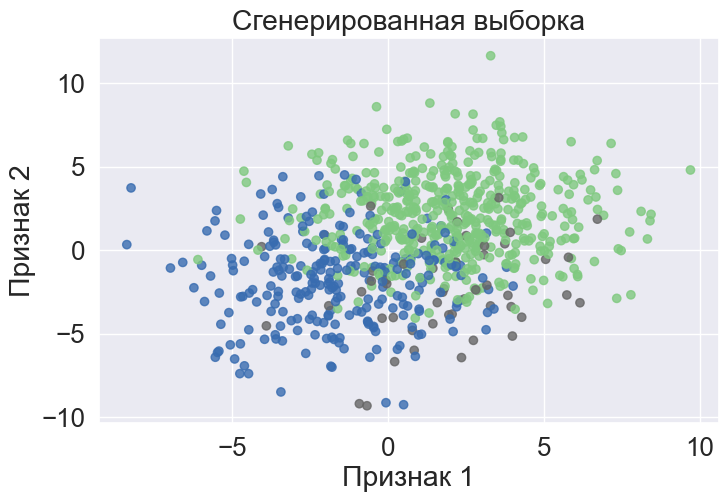

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("Сгенерированная выборка")
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap="Accent")
plt.grid()
plt.xlabel("Признак 1"), plt.ylabel("Признак 2")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

Микро-усреднение для $F_1$-меры:

In [ ]:
f1_micro = f1_score(y_test, clf.predict(X_test), average="micro")
print(f"F_1 (micro): {f1_micro:.3f}")

F_1 (micro): 0.821


Макро-усреднение для $F_1$-меры:

In [ ]:
f1_macro = f1_score(y_test, clf.predict(X_test), average="macro")
print(f"F_1 (macro): {f1_macro:.3f}")

F_1 (macro): 0.589


In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       150
           1       0.77      0.79      0.78        75
           2       0.25      0.07      0.11        15

    accuracy                           0.82       240
   macro avg       0.63      0.59      0.59       240
weighted avg       0.79      0.82      0.80       240



Полезные материалы:

[Связь между AUC-ROC и AUC-PR](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)

[Визуализация AUC-ROC](http://www.navan.name/roc/)